In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [35]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

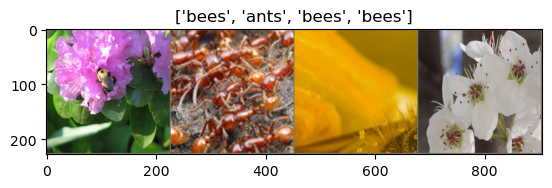

In [36]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])


In [37]:
model_ft = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft = model_ft.to(device)


In [ ]:
import copy 
import torch
import time
from torch import nn, optim
from torch.optim import lr_scheduler

# Remove weight decay from optimizer
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)  # Removed weight_decay
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

# Train the model
model_ft, train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/0
----------
train Loss: 0.6262 Acc: 0.6680
val Loss: 0.2434 Acc: 0.8954

Training complete in 0m 17s
Best val Acc: 0.8954


ValueError: x and y must have same first dimension, but have shapes (0,) and (1,)

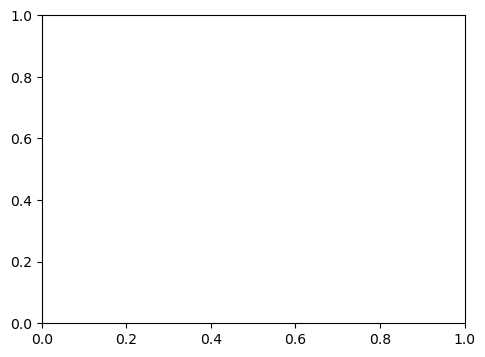

In [ ]:
# Plotting the loss and accuracy
epochs = range(1, 26)

plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_hist, label='Training Loss')
plt.plot(epochs, val_loss_hist, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_hist, label='Training Accuracy')
plt.plot(epochs, val_acc_hist, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

def visualize_predictions(model, num_images=5):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 5))

    with torch.no_grad():
        # Sample a few images from the validation loader
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Get predictions
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(1, num_images, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    plt.show()
                    return

# Call the function to visualize predictions
visualize_predictions(model_ft)

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

def generate_classification_report(model, dataloader):
    model.eval()
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    print("Classification Report:")
    print(classification_report(true_labels, pred_labels, target_names=class_names))

    overall_acc = (np.array(true_labels) == np.array(pred_labels)).mean()
    print(f"Overall Accuracy: {overall_acc:.4f}")

generate_classification_report(model_ft, dataloaders['val'])

### Cross Entropy with L2 regularization. 

In [ ]:
import copy 
import torch
import time
from torch import nn, optim
from torch.optim import lr_scheduler

# For classification, we should use CrossEntropyLoss
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

def compute_l2_penalty(model):
    """Compute L2 penalty for all parameters"""
    l2_reg = torch.tensor(0., requires_grad=True).to(device)
    for param in model.parameters():
        l2_reg = l2_reg + torch.norm(param, 2)**2
    return l2_reg

def train_model_l2(model, criterion, optimizer, scheduler, num_epochs=25, l2_lambda=0.01):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    
                    # Calculate main loss (CrossEntropyLoss for classification)
                    main_loss = criterion(outputs, labels)
                    
                    # Add L2 regularization term
                    l2_penalty = compute_l2_penalty(model)
                    loss = main_loss + l2_lambda * l2_penalty

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

# Train the model
model_ft, train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist = train_model_l2(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25, l2_lambda=0.01)

Epoch 0/24
----------
train Loss: 65.9598 Acc: 0.8197
val Loss: 64.7958 Acc: 0.8889

Epoch 1/24
----------
train Loss: 63.9211 Acc: 0.7705
val Loss: 62.4434 Acc: 0.8562

Epoch 2/24
----------
train Loss: 61.3789 Acc: 0.8648
val Loss: 60.1691 Acc: 0.9216

Epoch 3/24
----------
train Loss: 59.1951 Acc: 0.8402
val Loss: 58.0840 Acc: 0.8693

Epoch 4/24
----------
train Loss: 57.1517 Acc: 0.8197
val Loss: 55.9609 Acc: 0.8889

Epoch 5/24
----------
train Loss: 55.3348 Acc: 0.7828
val Loss: 54.5885 Acc: 0.7320

Epoch 6/24
----------
train Loss: 53.1591 Acc: 0.8484
val Loss: 52.3270 Acc: 0.8235

Epoch 7/24
----------
train Loss: 52.1594 Acc: 0.8238
val Loss: 51.9292 Acc: 0.8758

Epoch 8/24
----------
train Loss: 51.7850 Acc: 0.8811
val Loss: 51.6454 Acc: 0.8824

Epoch 9/24
----------
train Loss: 51.6885 Acc: 0.8279
val Loss: 51.4620 Acc: 0.9150

Epoch 10/24
----------
train Loss: 51.4283 Acc: 0.8566
val Loss: 51.2829 Acc: 0.9150

Epoch 11/24
----------
train Loss: 51.3248 Acc: 0.8361
val Loss:

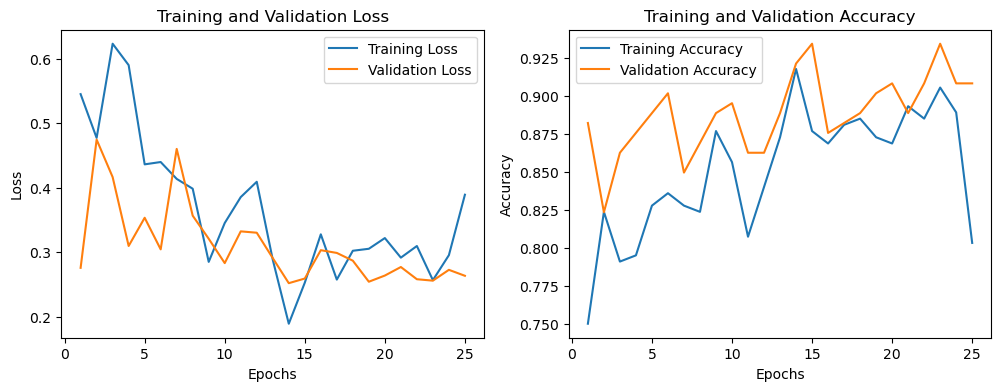

In [ ]:
# Plotting the loss and accuracy
epochs = range(1, 26)

plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_hist, label='Training Loss')
plt.plot(epochs, val_loss_hist, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_hist, label='Training Accuracy')
plt.plot(epochs, val_acc_hist, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

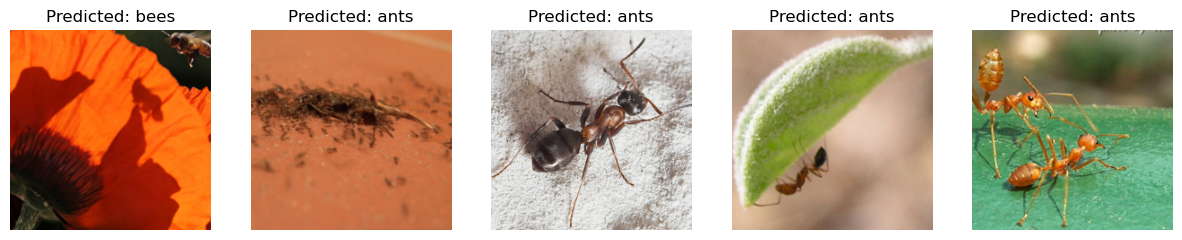

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

def visualize_predictions(model, num_images=5):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 5))

    with torch.no_grad():
        # Sample a few images from the validation loader
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Get predictions
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(1, num_images, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    plt.show()
                    return

# Call the function to visualize predictions
visualize_predictions(model_ft)


In [ ]:
import numpy as np
from sklearn.metrics import classification_report

def generate_classification_report(model, dataloader):
    model.eval()
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    print("Classification Report:")
    print(classification_report(true_labels, pred_labels, target_names=class_names))

    overall_acc = (np.array(true_labels) == np.array(pred_labels)).mean()
    print(f"Overall Accuracy: {overall_acc:.4f}")

generate_classification_report(model_ft, dataloaders['val'])

Classification Report:
              precision    recall  f1-score   support

        ants       0.94      0.91      0.93        70
        bees       0.93      0.95      0.94        83

    accuracy                           0.93       153
   macro avg       0.94      0.93      0.93       153
weighted avg       0.93      0.93      0.93       153

Overall Accuracy: 0.9346


### L1 regularization

END 

In [ ]:
import subprocess
subprocess.run(['git', 'add', '.'])
subprocess.run(['git', 'commit', '-m', 'Updated readme'])
subprocess.run(['git', 'push'])

CompletedProcess(args=['git', 'push'], returncode=0)